Let's play with code! And read stuff! And play some more with code!
Step one is to open the command palette by hitting the key-board looking button. From the menu select 'Restart kernel and clear all outputs.' That will give you a blank slate.
Step two is to open the command palette again and select 'Duplicate Notebook.' That will give you your own version of this thing, so that you can play around without risking blowing up the original.

# Part 1. Sister Clade Comparisons

This isn't the most powerful analysis of phylogenetic diversity variation, but it's straightforward and robust. Let's get a feel for it by analysing a slighlty modified version of the data set that Mitter et al. 1988 used to test the hypothesis that the evolution of herbivory in insects tends to increase species diversity. Herbivory has evolved independently several times in insects. All of this independent evolution is like replication of a natural evolutionary experiment. That replication let's us do a simple statistical analysis. In specific, we compare the species richness of clades that has evolved a trait, to the species richness of their sister clades (that haven't evolved the trait.) Since sister clades are just as old, and diverged from the same common ancestor, these contrasts are what we call phylogenetically-independent.

Note: As for all Jupyter notebooks, what we have here is mix of code for you to execute and text for you to read. Make sure you execute the code blocks in order. Select the block, and then hit that play button up top.

### Step 1. Read in some data to an R data frame.

In [ ]:
d<- read.csv(text='Herbivore,Herb-div,Sister,Sister-div
+ Tingidae,1800,Joppeicidae,1
+ Miridae,10000,Isometopidae,60
+ Trichophora,5000,Aradidae,1000
+ Elateridae,9000,Eucnemidae,1200
+ Scarabaeidae (in part),14000,Scarabaeinae + Aphondiinae,8200
+ Languriinae,410,Labarinae + Erotylidae,1750
+ Epilachninae,700,Coccinellini,250
+ Phytophaga,130000,other cucujoids,10000
+ symphyta,10000,Panorpida,80000
+ Oscinellinae + Chloropinae,2210,Siphonellopsinae,80
+ Tephritidae s.s.,4000,other tephritids,1733
+ Agromyzidae,2000,Clusiidae,200')


We had to read the data as an ugly chunk of text. That's a contraint of this Jupyter notebook. Let's have a look at the data frame, which we've assigned to the variable d.

In [ ]:
d ##not much of a command, but it will show us what we want to see.

It's just a table with four columns: the name of the herbivore clade, the species richness of the herbivore clade, the name of the matching sister clade, and the species richness of that sister clade.

### Step 2. Do a signed rank test.

The Wilcoxon Signed rank test is a simple non-parametric test. We have two groups of samples. We want to know whether or not those two groups of samples were taken from the same population (in the statistical sense). Here our sample observations are paired. We've got the diversity of a herbivorous insect clade, and we've got the diversity of it's sister clade. We want to know if the herbivorous insect clades tend to be more species rich than their sisters. Our null hypothesis is that in each pair of sister clades, the herbivorous clade has a 50% chance of being more diverse. It doesn't matter if a clade is composed of herbivorous species are not. Clades are clades. That's the hypothesis we try to reject.

In [ ]:
wilcox.test(d$Herb.div, d$Sister.div, paired=TRUE, alternative='greater')

That's it. With a p-value of 0.021, the difference is significant at the 0.05 alpha level. Herbivorous clades of insect do in fact tent to be more species rich. 

# Part 2. Playing with branching models

OK. As long as we've playing around in R, let's keep playing. In particular, let's use some branching models to simulate phylogenetic data, and test phylogenetic diversification hypotheses.

In [1]:
library(phytools)
library(diversitree)

Loading required package: ape
Loading required package: maps


Let's start by just simulating a phylogeny with the birth death model. We'll do that with a function from the phytools package. This function let's us specify a speciation rate (b), an extinction rate (d) and a few other parameters, such as how many species we want in our tree (n), or how long the simulation should run (t).

In [10]:
tree1 <- pbtree(b=1, d=0, t=5)

Have a look.

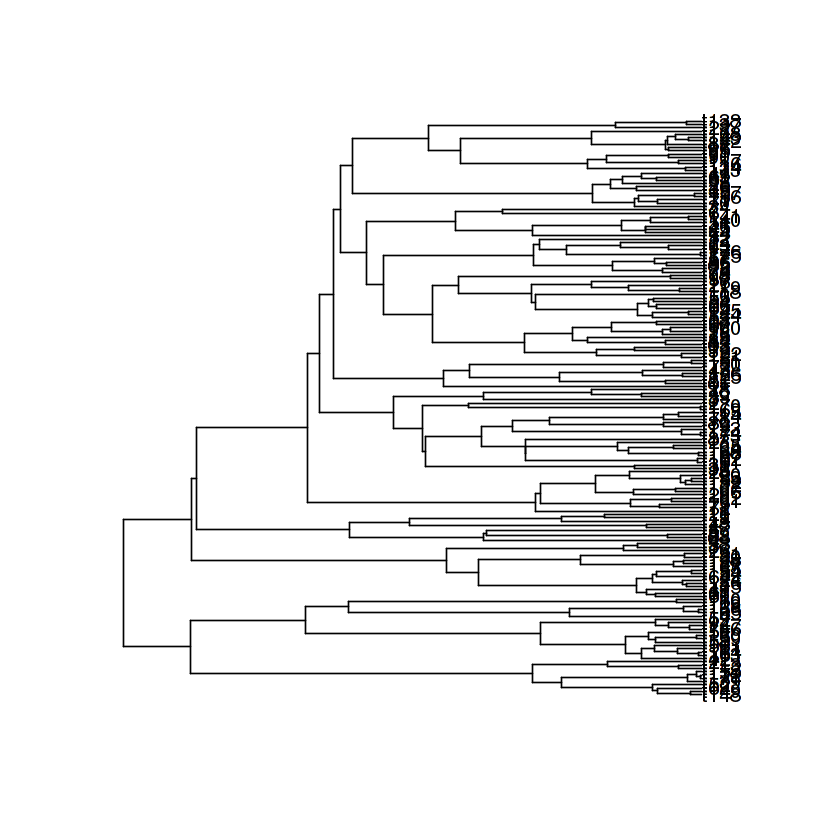

In [11]:
plot(tree1)

Given a phylogeny, we can also use a birth-death model to estimate rates of speciation and extinction. 

In [12]:
fit.bd <-birthdeath(tree1)
fit.bd


Estimation of Speciation and Extinction Rates
            with Birth-Death Models

     Phylogenetic tree: tree1 
        Number of tips: 176 
              Deviance: -1126.599 
        Log-likelihood: 563.2997 
   Parameter estimates:
      d / b = 0.4081076   StdErr = 0.116454 
      b - d = 0.7703439   StdErr = 0.100723 
   (b: speciation rate, d: extinction rate)
   Profile likelihood 95% confidence intervals:
      d / b: [0.2370864, 0.5404833]
      b - d: [0.6483481, 0.9078897]


That estimates the difference (and ratio) between the speciation and extinction rates, which is the net diversificaiton rate. In this case, we know exactly what new diversification should be since we set the parameters in the model used to simulate the tree. The speciation rate (b) we set to 1, and the extinction rate (d) we set to 0. Hence, the net diversification rate should be 1. The estimate you see probably isn't terrible. 

OK. Let's do some BiSSE stuff. Recall, that the BiSSE model is an extension of the simpler birth-death model of phylogenetic branching. First we'll set the parameters of BiSSE model and run a simulation. Then we'll use maximum likelihood to try estimate the correct paramters.

We pass the parameters as list, with values in this order: lambda1, lambda2, mu1, mu2, q01, q10. We'll call out parameter list pars.

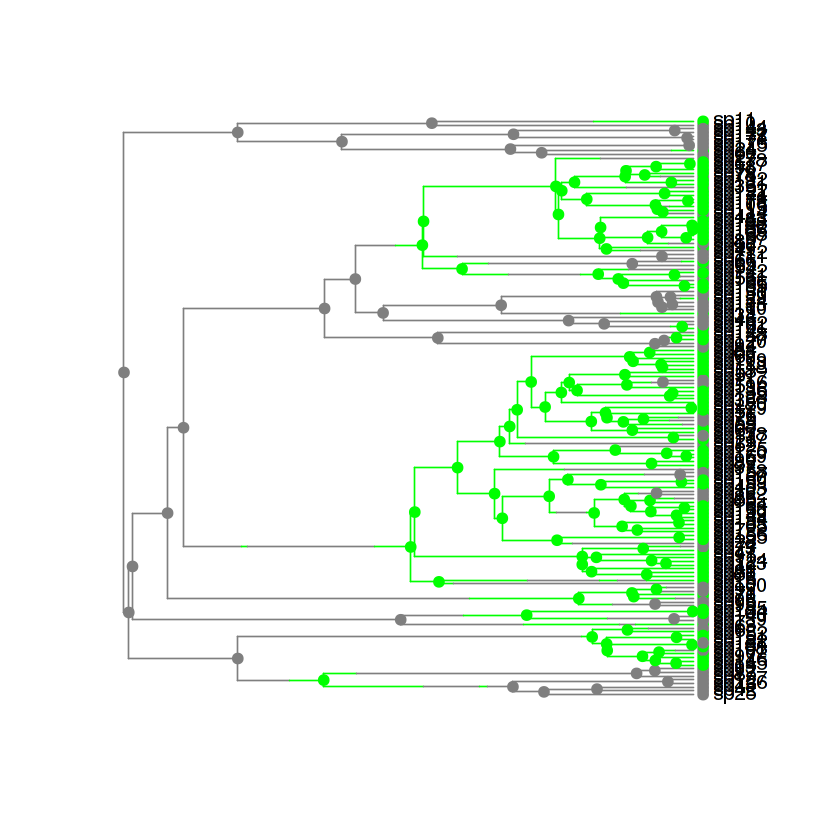

In [13]:
pars <- c(0.1, 0.3, 0.03, 0.03, 0.05, 0.1)
set.seed(2)
phy <- tree.bisse(pars, max.t=40, x0=0)
states <- phy$tip.state
#head(states)
cols = c('gray50', 'green')
plot(history.from.sim.discrete(phy, 0:1), phy, col=cols)

Use maximum likelihood to estimate parameters... 

In [14]:
lik <- make.bisse(phy, states) ##first we make an object that contains our tree and tip states
p <- starting.point.bisse(phy) ##given that tree, make a guess about what the parameter values might be
fit <- find.mle(lik, p) ##fit the model -- i.e., estimate parameters -- using maximum likelihood
round(coef(fit), 3) ##print the estimate model parameters, rounded to three digits

##it will take a few seconds for this to run

lambda0 lambda1     mu0     mu1     q01     q10 
  0.119   0.291   0.057   0.108   0.065   0.104

To save you from scrolling, here are the parameter values we specified in the simulation: lambda0 = 0.1, lambda1 =0.3, mu0 =0.03, mu1 = 0.03, q01 = 0.05, q10 = 0.1). Our estimates aren't too bad at all!

Next let's compare the full BiSSE model to one in which we constrain speciation and extinction rate to be unaffected by the state of our binary trait.

In [ ]:
lik.con <- constrain(lik, lambda1 ~ lambda0, mu1 ~ mu0)
fit.con <- find.mle(lik.con, p[argnames(lik.con)])
round(rbind(full=coef(fit), equal.rates=coef(fit.con, TRUE)), 3)
anova(fit, equal.rates=fit.con)

As expected, the full model is a better fit to the data, which after all were generated by the full model. We can tell that from the p-value (last column of second table), and we can also tell that by comparing [AIC values](https://en.wikipedia.org/wiki/Akaike_information_criterion).

Note, for teaching purposes this should suffice, but a heads up is in order. The statistics that we used here to compare models is actually too liberal, that is too prone to rejecting simpler hypotheses, when analysing real data. That's becuase real data were generated by real, funky evolutionary processes, that our simple stats are not accounting for. A more rigorous appraoch to selecting among competing BiSSE models entails lots of simulation. 